# 🌍 ECMWF Open Data – Interactive Exploration

This notebook demonstrates how to:
- Navigate ECMWF's open forecast data archive
- Download recent GRIB2 data
- Inspect and visualize selected variables (e.g. temperature)
- Plot geospatial data on a map using Cartopy

Data source: [ECMWF Open Forecasts](https://data.ecmwf.int/forecasts/)


In [1]:
import os
import urllib.request
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ipywidgets as widgets
from IPython.display import display


## 1: Data Access

We’ll dynamically access the ECMWF Open Data archive to retrieve the latest available forecast date.

This avoids hardcoding dates, since the archive is rolling (old files are deleted periodically).

The data is available from: https://data.ecmwf.int/forecasts/

In [2]:
base_url = "https://data.ecmwf.int/forecasts"
forecast_date = "20250624"
run_hour = "00z"
model_path = "ifs/0p25/enfo"
dir_url = f"{base_url}/{forecast_date}/{run_hour}/{model_path}/"

r = requests.get(dir_url)
soup = BeautifulSoup(r.text, "html.parser")

grib_files = [
    a['href'] for a in soup.find_all('a')
    if a.has_attr('href') and a['href'].endswith(".grib2") and "index" not in a['href']
]

if not grib_files:
    raise RuntimeError("No usable GRIB2 files found.")

selected_href = grib_files[0]
download_url = urljoin(dir_url, selected_href)
selected_filename = selected_href.strip("/").split("/")[-1]
local_path = f"../data/{selected_filename}"

os.makedirs("../data", exist_ok=True)

# Download if not already there
if not os.path.exists(local_path):
    print(f"Downloading {selected_filename} ...")
    urllib.request.urlretrieve(download_url, local_path)
    print(f"File saved to: {local_path}")
else:
    print(f"File already exists: {local_path}")


RuntimeError: No usable GRIB2 files found.

In [ ]:
# 📥 Interactive GRIB File Selection and Download

import os
from urllib.parse import urljoin
import requests
from bs4 import BeautifulSoup
import ipywidgets as widgets
from IPython.display import display

BASE_URL = "https://data.ecmwf.int/forecasts/"

# --- Step 1: Get available dates from the rolling archive ---
r = requests.get(BASE_URL)
soup = BeautifulSoup(r.text, "html.parser")

available_dates = sorted([
    a.text.strip("/") for a in soup.find_all("a")
    if a.text.strip("/").isdigit() and len(a.text.strip("/")) == 8
], reverse=True)

# --- Step 2: Setup widgets ---
date_dropdown = widgets.Dropdown(
    options=available_dates,
    value=available_dates[0],
    description="📅 Date:"
)

run_hour_dropdown = widgets.Dropdown(
    options=["00z", "12z"],
    value="00z",
    description="⏰ Run:"
)

model_dropdown = widgets.Dropdown(
    options=[
        "ifs/0p4-beta",    # deterministic high-res
        "ifs/0p25/enfo",   # ensemble forecast
        "aifs/0p4-beta",   # AI deterministic
        "aifs/0p4/enfo"    # AI ensemble (new)
    ],
    value="ifs/0p25/enfo",
    description="📦 Model:"
)

download_button = widgets.Button(description="⬇️ Download GRIB File", button_style="primary")
download_output = widgets.Output()

# --- Step 3: Download logic ---
def handle_download(_):
    download_output.clear_output()
    with download_output:
        date = date_dropdown.value
        hour = run_hour_dropdown.value
        model = model_dropdown.value
        folder_url = f"{BASE_URL}{date}/{hour}/{model}/"
        
        print(f"📅 Date:\n\n{date}")
        print(f"⏰ Run:\n\n{hour}")
        print(f"📦 Model:\n\n{model}")
        print("📁 Forecast folder URL:", folder_url)

        try:
            r = requests.get(folder_url)
            r.raise_for_status()
            soup = BeautifulSoup(r.text, "html.parser")
            grib_files = [
                a["href"] for a in soup.find_all("a")
                if a["href"].endswith(".grib2") and "index" not in a["href"]
            ]
            if not grib_files:
                print("❌ No GRIB2 files found in selected folder.")
                return
        except Exception as e:
            print("❌ Failed to access forecast folder:", e)
            return

        selected_href = grib_files[0]
        selected_file = os.path.basename(selected_href)
        download_url = urljoin(folder_url, selected_href)
        local_path = os.path.join("../data", selected_file)

        print("📄 Selected file:", selected_href)
        print("🌐 Download URL:", download_url)

        os.makedirs("../data", exist_ok=True)

        if not os.path.exists(local_path):
            print("⬇️ Downloading...")
            try:
                with requests.get(download_url, stream=True) as response:
                    response.raise_for_status()
                    with open(local_path, "wb") as f:
                        for chunk in response.iter_content(chunk_size=8192):
                            f.write(chunk)
                print(f"✅ File saved to: {local_path}")
            except Exception as e:
                print("❌ Download failed:", e)
                return
        else:
            print(f"✔️ File already exists: {local_path}")

        globals()["local_path"] = local_path  # so other cells can use it

# Connect download button to logic
download_button.on_click(handle_download)

# --- Step 4: Show UI ---
display(widgets.VBox([
    date_dropdown,
    run_hour_dropdown,
    model_dropdown,
    download_button,
    download_output
]))


## 2: Load and Explore Forecast Data

We'll open the file using `cfgrib` and show basic info.


In [4]:
ds = xr.open_dataset(local_path, engine="cfgrib", backend_kwargs={"filter_by_keys": {"dataType": "cf"}})
ds


skipping variable: paramId==228026 shortName='mx2t3'
Traceback (most recent call last):
  File "/Users/valtze/miniforge3/envs/ecmwf-open-data-jupyter/lib/python3.10/site-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/valtze/miniforge3/envs/ecmwf-open-data-jupyter/lib/python3.10/site-packages/cfgrib/dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='step' value=Variable(dimensions=(), data=np.float64(0.0)) new_value=Variable(dimensions=(), data=np.float64(3.0))
skipping variable: paramId==228027 shortName='mn2t3'
Traceback (most recent call last):
  File "/Users/valtze/miniforge3/envs/ecmwf-open-data-jupyter/lib/python3.10/site-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/valtze/miniforge3/envs/ecmwf-open-data-jupyter/lib/python3.10/site-packages/cf

<xarray.Dataset> Size: 623MB
Dimensions:             (latitude: 721, longitude: 1440, isobaricInhPa: 13,
                         soilLayer: 4)
Coordinates: (12/14)
    number              int64 8B ...
    time                datetime64[ns] 8B ...
    step                timedelta64[ns] 8B ...
    surface             float64 8B ...
  * latitude            (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude           (longitude) float64 12kB -180.0 -179.8 ... 179.5 179.8
    ...                  ...
  * soilLayer           (soilLayer) float64 32B 1.0 2.0 3.0 4.0
    nominalTop          float64 8B ...
    mostUnstableParcel  float64 8B ...
    meanSea             float64 8B ...
    heightAboveGround   float64 8B ...
    entireAtmosphere    float64 8B ...
Data variables: (12/36)
    str                 (latitude, longitude) float32 4MB ...
    q                   (isobaricInhPa, latitude, longitude) float32 54MB ...
    sot                 (soilLayer, latitude, longitude) float32 17MB ...
    ttr                 (latitude, longitude) float32 4MB ...
    ewss                (latitude, longitude) float32 4MB ...
    gh                  (isobaricInhPa, latitude, longitude) float32 54MB ...
    ...                  ...
    sp                  (latitude, longitude) float32 4MB ...
    sithick             (latitude, longitude) float32 4MB ...
    tcw                 (latitude, longitude) float32 4MB ...
    strd                (latitude, longitude) float32 4MB ...
    ssr                 (latitude, longitude) float32 4MB ...
    tcwv                (latitude, longitude) float32 4MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-07-30T16:12 GRIB to CDM+CF via cfgrib-0.9.1...

## 3: Select and Plot a Variable

Choose a variable to explore using the dropdown. If it has pressure levels, you can select one.


Dropdown(description='Variable:', options=('str', 'q', 'sot', 'ttr', 'ewss', 'gh', 'nsss', 'w', 't', 'vo', 'ro…

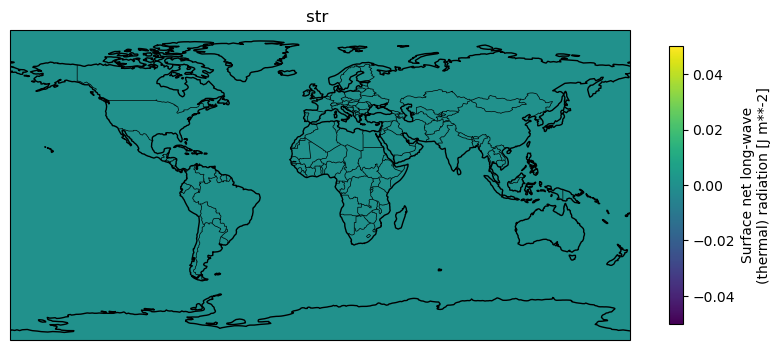

Dropdown(description='Level (hPa):', options=(np.float64(1000.0), np.float64(925.0), np.float64(850.0), np.flo…

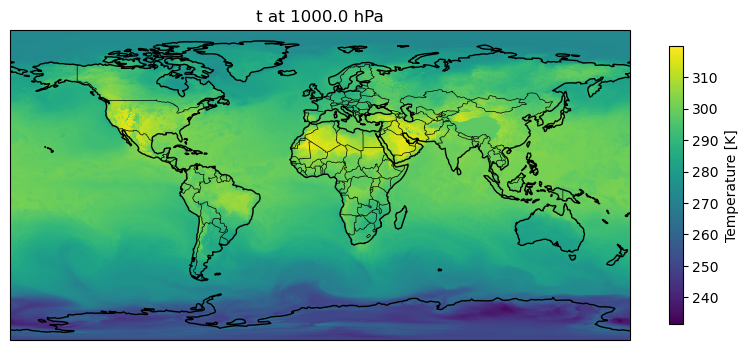

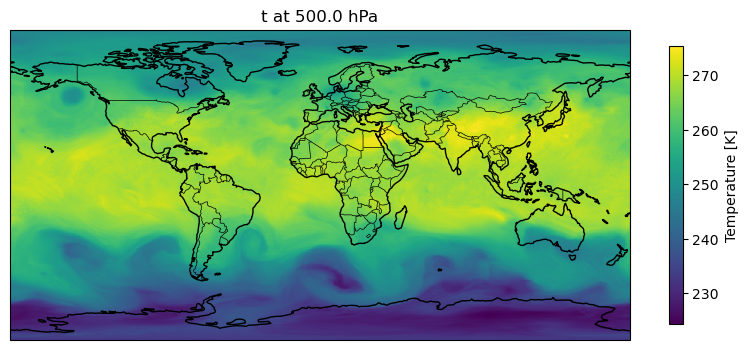

In [5]:
def plot_variable(varname, level=None):
    da = ds[varname]
    if level is not None and 'isobaricInhPa' in da.dims:
        da = da.sel(isobaricInhPa=level)

    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    da.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="viridis", cbar_kwargs={"shrink": 0.6})
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_title(f"{varname} {'at ' + str(level)+' hPa' if level else ''}")
    plt.show()

# Dropdown
var_names = list(ds.data_vars)
var_widget = widgets.Dropdown(options=var_names, description='Variable:')

def update_plot(varname):
    da = ds[varname]
    if "isobaricInhPa" in da.dims:
        level_widget = widgets.Dropdown(
            options=da.coords["isobaricInhPa"].values,
            description="Level (hPa):"
        )
        def on_level_change(change):
            plot_variable(varname, level=change["new"])
        level_widget.observe(on_level_change, names="value")
        display(level_widget)
        plot_variable(varname, level=da.coords["isobaricInhPa"].values[0])
    else:
        plot_variable(varname)

def on_var_change(change):
    update_plot(change["new"])

var_widget.observe(on_var_change, names="value")
display(var_widget)

# Initial plot
update_plot(var_widget.value)


In [ ]:
# import os
# from urllib.parse import urljoin
# import requests
# from bs4 import BeautifulSoup
# import ipywidgets as widgets
# from IPython.display import display, HTML

# BASE_URL = "https://data.ecmwf.int/forecasts/"

# # --- Step 1: Get available forecast dates ---
# response = requests.get(BASE_URL)
# soup = BeautifulSoup(response.text, "html.parser")

# available_dates = sorted([
#     a.text.strip("/") for a in soup.find_all("a")
#     if a.text.strip("/").isdigit() and len(a.text.strip("/")) == 8
# ], reverse=True)

# # --- Step 2: Widgets for date, time, model, forecast step ---
# date_dropdown = widgets.Dropdown(
#     options=available_dates,
#     value=available_dates[0],
#     description="📅 Date:"
# )

# run_hour_dropdown = widgets.Dropdown(
#     options=["00z", "06z", "12z", "18z"],
#     value="00z",
#     description="⏰ Run Hour:"
# )

# model_dropdown = widgets.Dropdown(
#     options=[
#         "0p25/enfo",
#         "0p25/oper",
#         "0p25/waef",
#         "0p25/wave"
#     ],
#     value="0p25/oper",
#     description="📦 Model:"
# )

# forecast_step_dropdown = widgets.Dropdown(
#     options=[],  # populated later
#     description="🕓 Forecast H:"
# )

# download_button = widgets.Button(description="Download GRIB File", button_style="primary")
# download_output = widgets.Output()

# # --- Step 3: Update forecast hour dropdown based on folder contents ---
# def update_forecast_steps(*args):
#     with download_output:
#         download_output.clear_output()
#         print("🔎 Fetching available forecast steps...")

#         folder_url = f"{BASE_URL}{date_dropdown.value}/{run_hour_dropdown.value}/ifs/{model_dropdown.value}/"
#         try:
#             r = requests.get(folder_url)
#             r.raise_for_status()
#             soup = BeautifulSoup(r.text, "html.parser")
#             grib_files = [
#                 a["href"] for a in soup.find_all("a")
#                 if a["href"].endswith(".grib2") and "index" not in a["href"]
#             ]
#             forecast_steps = {
#                 f.split("-")[1]: f for f in grib_files
#             }
#             forecast_step_dropdown.options = sorted(forecast_steps.keys(), key=lambda x: int(x.replace("h", "")))
#             forecast_step_dropdown._step_files = forecast_steps
#             print("✅ Forecast hours updated.")
#         except Exception as e:
#             forecast_step_dropdown.options = []
#             print(f"❌ Failed to fetch forecast steps: {e}")

# # Connect dropdown changes
# for widget in (date_dropdown, run_hour_dropdown, model_dropdown):
#     widget.observe(update_forecast_steps, names="value")

# update_forecast_steps()  # initial call

# # --- Step 4: Download logic ---
# def handle_download(_):
#     download_output.clear_output()
#     with download_output:
#         date = date_dropdown.value
#         hour = run_hour_dropdown.value
#         model = model_dropdown.value
#         step_key = forecast_step_dropdown.value
#         step_file = forecast_step_dropdown._step_files.get(step_key)

#         if not step_file:
#             print("⚠️ No file selected.")
#             return

#         folder_url = f"{BASE_URL}{date}/{hour}/ifs/{model}/"
#         download_url = urljoin(folder_url, step_file)
#         filename = os.path.basename(step_file)
#         local_path = os.path.join("../data", filename)

#         print(f"📄 Selected: {step_file}")
#         print(f"🔗 URL: ", download_url)
#         print("⬇️ Downloading...")

#         os.makedirs("../data", exist_ok=True)

#         try:
#             with requests.get(download_url, stream=True) as response:
#                 response.raise_for_status()
#                 with open(local_path, "wb") as f:
#                     for chunk in response.iter_content(chunk_size=8192):
#                         f.write(chunk)
#             print(f"✅ File saved to: {local_path}")
#             globals()["local_path"] = local_path
#         except Exception as e:
#             print(f"❌ Download failed: {e}")

# download_button.on_click(handle_download)

# # --- Step 5: Display UI ---
# display(widgets.VBox([
#     date_dropdown,
#     run_hour_dropdown,
#     model_dropdown,
#     forecast_step_dropdown,
#     download_button,
#     download_output
# ]))
